In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sktime.split import temporal_train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer


In [52]:
csv_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'clean_data', 'main_df_clean.csv'))

merged_df = pd.read_csv(csv_path)

merged_df["Date"] = pd.to_datetime(merged_df["Date"], errors="coerce", format="%m/%Y")
merged_df["Date"] = pd.PeriodIndex(merged_df["Date"], freq="M")

numeric_cols = merged_df.select_dtypes(include=[np.number]).columns

imputer = IterativeImputer(random_state=42)
merged_df[numeric_cols] = imputer.fit_transform(merged_df[numeric_cols])

merged_df.head()


,Unnamed: 0,Date,brl Exchange Rate,vnd Exchange Rate,hnl Exchange Rate,idr Exchange Rate,Coffee,Milk,Sugar,Tea,cop Exchange Rate,close
0,0.0,NaT,0.000006,5479.329529,2.0,1804.85,0.7583,0.041316,0.1420,1.147273,440.08,79.99
1,1.0,NaT,0.000010,5479.329529,2.0,1809.87,0.8401,0.057037,0.1465,0.958396,451.72,93.79
2,2.0,NaT,0.000016,5479.329529,4.0,1820.35,0.9396,0.067354,0.1531,0.873620,463.40,92.14
3,3.0,NaT,0.000021,5479.329529,4.0,1826.05,0.9373,0.067549,0.1524,0.883644,474.62,93.73
4,4.0,NaT,0.000023,5563.430866,4.2,1831.40,0.9202,0.070450,0.1462,0.848309,485.99,94.05


In [53]:
window_size = 30 
X = []
y = []

for i in range(len(merged_df) - window_size):
    X.append(merged_df['Coffee'].iloc[i:i+window_size].values) 
    y.append(merged_df['Coffee'].iloc[i+window_size]) 

X = np.array(X).reshape(-1, window_size)
y = np.array(y)

X_train, X_test, y_train, y_test = temporal_train_test_split(X, y, test_size=0.2)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train size: 311, Test size: 78


In [54]:
alphas = [0.01, 0.1, 1, 10, 100]
best_alpha = None
best_rmse = float("inf")

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    y_pred_val = ridge.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")

ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_scaled, y_train)

y_pred = ridge.predict(X_test_scaled)


Best alpha: 1


In [55]:
def print_metrics(y_true, y_pred):
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.2f}")

print_metrics(y_test, y_pred)


MAE: 0.10
MSE: 0.02
RMSE: 0.12
R²: 0.95


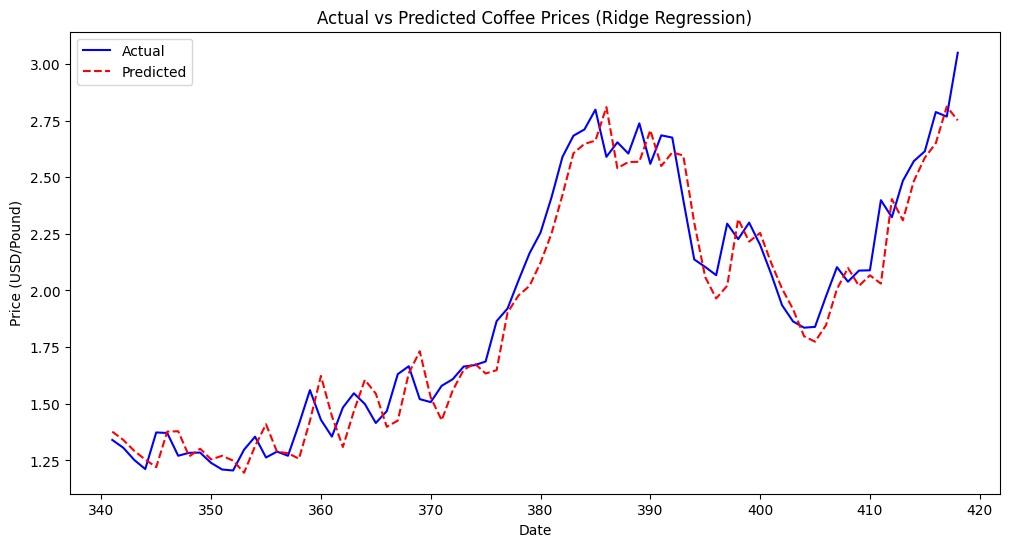

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_test):], y_test, label='Actual', color="blue")
plt.plot(merged_df.index[-len(y_test):], y_pred, label='Predicted', linestyle="dashed", color="red")
plt.title('Actual vs Predicted Coffee Prices (Ridge Regression)')
plt.xlabel('Date')
plt.ylabel('Price (USD/Pound)')
plt.legend()
plt.show()
